<a href="https://colab.research.google.com/github/Apoorvmittal11/23-CS-072-ML-LAB-EXPERIMENT/blob/main/23-CS-072%20EXPERIMENT10/Experiment_10_Solving_a_Markov_Decision_Process_(MDP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Experiment 10 : Solving a Markov Decision Process (MDP)**

**1. Learning Objectives**

Upon successful completion of this assignment, students will be able to:

* Define and understand the core components of a Markov Decision Process (MDP):

  * States (S)

  * Actions (A)

  * Transition Model (T)

  * Reward Function (R)

  * Discount Factor (gamma)

* Translate a "grid world" problem into a formal MDP structure.

* Implement the Value Iteration algorithm from scratch using only NumPy.

* Understand and apply the Bellman Optimality Equation to calculate state values.

* Extract an optimal policy (the best action for each state) from a converged value
function.

* Visualize and interpret the resulting value function and policy.

* Analyze how hyperparameters ( gamma and "living penalty") affect the agent's final
behavior.

**2. Introduction**
This assignment is your first step into Reinforcement Learning. We will focus on the
"planning" problem, where we have a perfect model of the environment (the MDP) and want
to find the best possible plan (the optimal policy) before the agent even takes a step.
You will be implementing Value Iteration, a classic algorithm that repeatedly applies the
Bellman equation to find the true "value" of being in every state.1 Once we know the value of
all states, figuring out the best action is easy: just move to the state with the highest value! You will solve the "GridWorld" problem, a 3x4 grid with a goal, a "pit" (danger), and walls.
Your agent must learn the shortest, safest path to the goal.

**3. Prerequisites**

Ensure your Python environment has the following libraries installed:

In [1]:
pip install numpy matplotlib seaborn

**4. Experiment Tasks**

**Task 1: Define the GridWorld (The MDP) (30 Marks)**

First, we must define the "rules of the game." You will not use any existing RL libraries (like
gym ). You will define the world yourself.

The world is a 3x4 grid:

* States (S): The grid cells. (0,0) , (0,1) , (0,2) , (0,3) , etc.

* Walls: There is a wall at (1,1) . The agent cannot move into this state.

* Terminal States:

  * Goal: (0,3) (e.g., a gem)

  * Pit: (1,3) (e.g., a fire pit)

* Actions (A): The agent can try to move ['up', 'down', 'left', 'right'] .

1. Define States: Create a list or set of all valid states (all (row, col) tuples, except the wall
at (1,1) ).

2. Define Rewards (R): Create a dictionary or function that defines the reward R(s) for
being in a state s .

  * Goal (0,3) : +1

  * Pit (1,3) : 1

  * All other states: 0.04 (This is a "living penalty" to encourage the agent to find the
shortest path).

3. Define Discount Factor: Use gamma = 0.99 .

4. Define Transition Model (T): This is the most important part. You must create a
function that defines the probabilities of moving. The world is stochastic
(unpredictable).

* If the agent chooses an action (e.g., 'up' ):

  * 80% chance it goes in the intended direction (e.g., 'up' ).

  * 10% chance it slips and goes 90 degrees to the left (e.g., 'left' ).

  * 10% chance it slips and goes 90 degrees to the right (e.g., 'right' ).

* Handling Walls/Boundaries: If a move (intended or slipped) would land the agent
in a wall (like (1,1) ) or off the grid, the agent stays in its current state.

* Terminal States: Once the agent enters a terminal state (Goal or Pit), it stays there
and receives no further rewards. (For Value Iteration, we can simplify this: terminal
states have a value of 0 and no actions leading out).

To Implement: Create a helper function get_next_states(s, a) that, given a state s and action
a, returns a list of (probability, next_state) tuples.

For example, from (0,0):
get_next_states((0,0), 'right') might return:

[(0.8, (0,1)), (0.1, (0,0)), (0.1, (1,0))]

(0.8 for 'right', 0.1 for 'up' (slips left, hits wall, stays at (0,0)), 0.1 for 'down' (slips right)).

In [3]:
import numpy as np
# 1. Grid Dimensions
rows = 3
cols = 4

# 2. Define States (excluding wall)
wall = (1, 1)
terminal_states = [(0, 3), (1, 3)]
states = [(r, c) for r in range(rows) for c in range(cols) if (r, c) != wall]

print("Valid States:")
print(states)

# 3. Define Rewards
rewards = {}
for state in states:
    if state == (0,3):
        rewards[state] = 1       # Goal
    elif state == (1,3):
        rewards[state] = -1      # Pit
    else:
        rewards[state] = -0.04   # Living penalty

print("\nRewards:")
for s in states:
    print(f"State {s}: Reward = {rewards[s]}")

# 4. Define Actions
actions = ['up', 'down', 'left', 'right']

# Action effects as (delta_row, delta_col)
action_effects = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

# 5. Discount Factor
gamma = 0.99

# 6. Transition Function
def get_next_states(state, action):
    """
    Returns list of (probability, next_state) tuples
    """
    # Terminal states: no further moves
    if state in terminal_states:
        return [(1.0, state)]

    # Determine slips
    if action == 'up':
        intended = 'up'
        left_slip = 'left'
        right_slip = 'right'
    elif action == 'down':
        intended = 'down'
        left_slip = 'right'
        right_slip = 'left'
    elif action == 'left':
        intended = 'left'
        left_slip = 'down'
        right_slip = 'up'
    elif action == 'right':
        intended = 'right'
        left_slip = 'up'
        right_slip = 'down'

    probs = [(0.8, intended), (0.1, left_slip), (0.1, right_slip)]
    result = []

    for p, a in probs:
        dr, dc = action_effects[a]
        new_r = state[0] + dr
        new_c = state[1] + dc

        # Check if new state is valid (inside grid and not a wall)
        if (new_r, new_c) not in states:
            new_r, new_c = state

        result.append((p, (new_r, new_c)))

    return result

print("\nExample: Next states from (0,0) moving 'right':")
for prob, next_state in get_next_states((0,0), 'right'):
    print(f"Probability: {prob}, Next State: {next_state}")


Valid States:
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]

Rewards:
State (0, 0): Reward = -0.04
State (0, 1): Reward = -0.04
State (0, 2): Reward = -0.04
State (0, 3): Reward = 1
State (1, 0): Reward = -0.04
State (1, 2): Reward = -0.04
State (1, 3): Reward = -1
State (2, 0): Reward = -0.04
State (2, 1): Reward = -0.04
State (2, 2): Reward = -0.04
State (2, 3): Reward = -0.04

Example: Next states from (0,0) moving 'right':
Probability: 0.8, Next State: (0, 1)
Probability: 0.1, Next State: (0, 0)
Probability: 0.1, Next State: (1, 0)


**Task 2: Value Iteration Algorithm (From Scratch) (40 Marks)**

Now you will implement the algorithm to solve the MDP.

1. Initialize Value Function: Create your main data structure, V , which will be a
dictionary or a 2D NumPy array. V[s] stores the current estimated value of being in states . Initialize the value of all states to 0.0.

2. Implement Value Iteration:

* You will loop until the V function converges.

* Convergence is when the maximum change in V for any state in a single iteration is
very small.

* Use a threshold theta = 0.0001 .

3. Run: Run your value_iteration function. It should return the final, converged V table.

In [6]:
import numpy as np
# 1. Use GridWorld from Task 1
rows = 3
cols = 4
wall = (1, 1)
terminal_states = [(0, 3), (1, 3)]
states = [(r, c) for r in range(rows) for c in range(cols) if (r, c) != wall]

rewards = {}
for state in states:
    if state == (0,3):
        rewards[state] = 1       # Goal
    elif state == (1,3):
        rewards[state] = -1      # Pit
    else:
        rewards[state] = -0.04   # Living penalty

actions = ['up', 'down', 'left', 'right']

action_effects = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

gamma = 0.99

def get_next_states(state, action):
    if state in terminal_states:
        return [(1.0, state)]

    if action == 'up':
        intended = 'up'
        left_slip = 'left'
        right_slip = 'right'
    elif action == 'down':
        intended = 'down'
        left_slip = 'right'
        right_slip = 'left'
    elif action == 'left':
        intended = 'left'
        left_slip = 'down'
        right_slip = 'up'
    elif action == 'right':
        intended = 'right'
        left_slip = 'up'
        right_slip = 'down'

    probs = [(0.8, intended), (0.1, left_slip), (0.1, right_slip)]
    result = []

    for p, a in probs:
        dr, dc = action_effects[a]
        new_r = state[0] + dr
        new_c = state[1] + dc
        if (new_r, new_c) not in states:
            new_r, new_c = state
        result.append((p, (new_r, new_c)))

    return result


# 2. Initialize Value Function
V = {s: 0.0 for s in states}


# 3. Value Iteration Algorithm

def value_iteration(states, actions, rewards, gamma, theta=0.0001):
    V = {s: 0.0 for s in states}  # Initialize value function
    iteration = 0

    while True:
        delta = 0
        new_V = V.copy()

        for s in states:
            if s in terminal_states:
                continue

            # Compute value for each action
            action_values = []
            for a in actions:
                total = 0
                for prob, next_state in get_next_states(s, a):
                    total += prob * (rewards[next_state] + gamma * V[next_state])
                action_values.append(total)

            best_value = max(action_values)
            new_V[s] = best_value
            delta = max(delta, abs(V[s] - best_value))

        V = new_V
        iteration += 1
        if delta < theta:
            break

    print(f"Converged after {iteration} iterations")
    return V

# Run Value Iteration
V_final = value_iteration(states, actions, rewards, gamma)

print("\nFinal Value Function:")
for r in range(rows):
    row_values = []
    for c in range(cols):
        if (r, c) == wall:
            row_values.append("WALL")
        elif (r, c) in V_final:
            row_values.append(round(V_final[(r, c)], 3))
        else:
            row_values.append(None)
    print(row_values)


Converged after 20 iterations

Final Value Function:
[0.824, 0.893, 0.955, 0.0]
[0.764, 'WALL', 0.688, 0.0]
[0.698, 0.639, 0.606, 0.382]


**Task 3: Policy Extraction (From Scratch) (15 Marks)**

The V table tells you how good each state is, but not what to do. Now, you must extract the
optimal policy ( Pi ) from V .

1. Create Policy Table: Create a new table Pi (dictionary or 2D array) to store the best
action for each state.

2. One-Step Lookahead: For each state s :

* Calculate the expected value ( Q(s,a) ) for all four actions, just like you did in Task 2.

* Find the action a that gives the maximum Q(s,a) value.

* Store this best action (e.g., 'up' ) in Pi[s] .

3. Return: Return the final Pi table. This Pi is the optimal policy!

In [7]:
# 1. Initialize Policy Table
policy = {s: None for s in states}

# 2. One-Step Lookahead Function
def one_step_lookahead(state, V):
    """
    Returns a dictionary of action -> expected value (Q(s,a))
    """
    Q = {}
    for a in actions:
        total = 0
        for prob, next_state in get_next_states(state, a):
            total += prob * (rewards[next_state] + gamma * V[next_state])
        Q[a] = total
    return Q

# 3. Extract Optimal Policy
for s in states:
    if s in terminal_states or s == wall:
        policy[s] = None  # No action for terminal or wall
    else:
        Q_s = one_step_lookahead(s, V_final)
        best_action = max(Q_s, key=Q_s.get)
        policy[s] = best_action

# 4. Display Policy Grid
print("\nOptimal Policy (Pi):")
for r in range(rows):
    row_actions = []
    for c in range(cols):
        if (r, c) == wall:
            row_actions.append("WALL")
        elif (r, c) in terminal_states:
            row_actions.append("TERM")
        else:
            row_actions.append(policy[(r, c)])
    print(row_actions)



Optimal Policy (Pi):
['right', 'right', 'right', 'TERM']
['up', 'WALL', 'up', 'TERM']
['up', 'left', 'up', 'left']


**Task 4: Visualization and Analysis (15 Marks)**

1. Visualize Value Function: Write a simple function to print your V table in a 3x4 grid
format. Use seaborn.heatmap for a much better visualization.

2. Visualize Policy: Write a simple function to print your Pi table in a 3x4 grid, using
arrows ( ^ , v , < , > ) to represent the actions.

3. Analyze:

* Question 1: Run your full pipeline. Print the final V table and the final Pi table.
Does the policy make sense? Does it correctly avoid the pit and find the goal?

* Question 2: Change the "living penalty" R(s) from 0.04 to 0.0 . Rerun. Does the
policy change? Why or why not?

* Question 3: Change the "living penalty" R(s) from 0.04 to 0.5 (a high penalty).
Rerun. What happens to the policy? Does the agent take a different path? Why?

Default Living Penalty = 0.04 
Converged after 20 iterations


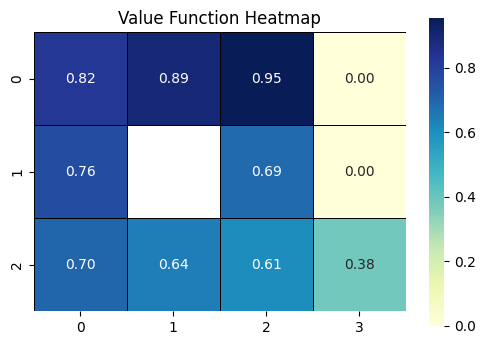


Optimal Policy Grid:
['>' '>' '>' 'TERM']
['^' 'WALL' '^' 'TERM']
['^' '<' '^' '<']

Living Penalty = 0.0 
Converged after 65 iterations


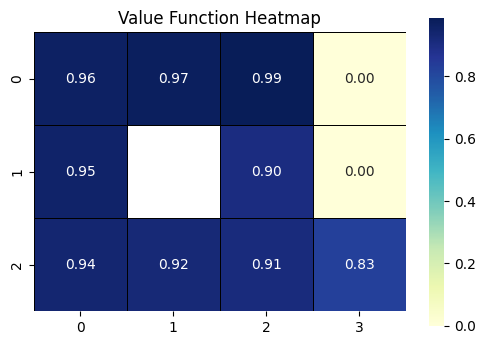


Optimal Policy Grid:
['>' '>' '>' 'TERM']
['^' 'WALL' '<' 'TERM']
['^' '<' '<' 'v']

High Living Penalty = 0.5 
Converged after 17 iterations


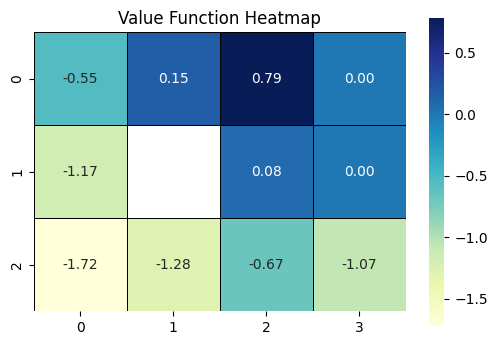


Optimal Policy Grid:
['>' '>' '>' 'TERM']
['^' 'WALL' '^' 'TERM']
['^' '>' '^' '<']


In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Helper: Visualize Value Function
def visualize_value_function(V):
    grid = np.zeros((rows, cols))
    for r in range(rows):
        for c in range(cols):
            if (r, c) in V:
                grid[r, c] = V[(r, c)]
            else:
                grid[r, c] = np.nan  # For wall

    plt.figure(figsize=(6,4))
    sns.heatmap(grid, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, square=True,
                linewidths=0.5, linecolor='black')
    plt.title("Value Function Heatmap")
    plt.show()

# Helper: Visualize Policy
arrow_map = {'up':'^', 'down':'v', 'left':'<', 'right':'>'}

def visualize_policy(policy):
    grid = np.empty((rows, cols), dtype=object)
    for r in range(rows):
        for c in range(cols):
            if (r, c) == wall:
                grid[r, c] = "WALL"
            elif (r, c) in terminal_states:
                grid[r, c] = "TERM"
            else:
                grid[r, c] = arrow_map[policy[(r, c)]]
    print("\nOptimal Policy Grid:")
    for row in grid:
        print(row)

# Helper: Run Full Pipeline
def run_mdp(living_penalty=-0.04):
    # 1. Update rewards
    rewards_local = {}
    for state in states:
        if state == (0,3):
            rewards_local[state] = 1
        elif state == (1,3):
            rewards_local[state] = -1
        else:
            rewards_local[state] = living_penalty

    # 2. Value Iteration
    V_local = value_iteration(states, actions, rewards_local, gamma)

    # 3. Extract Policy
    policy_local = {s: None for s in states}
    for s in states:
        if s in terminal_states or s == wall:
            policy_local[s] = None
        else:
            Q_s = one_step_lookahead(s, V_local)
            best_action = max(Q_s, key=Q_s.get)
            policy_local[s] = best_action

    # 4. Visualize
    visualize_value_function(V_local)
    visualize_policy(policy_local)

    return V_local, policy_local

# Question 1: Default living penalty = 0.04
print("Default Living Penalty = 0.04 ")
V1, Pi1 = run_mdp(living_penalty=-0.04)

# Question 2: Living penalty = 0.0
print("\nLiving Penalty = 0.0 ")
V2, Pi2 = run_mdp(living_penalty=0.0)

# Question 3: High Living Penalty = 0.5
print("\nHigh Living Penalty = 0.5 ")
V3, Pi3 = run_mdp(living_penalty=-0.5)